In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def load_train_valid_sets(data_dir='./data', valid_split=0.1, batch_size=256):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    trainset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=True, download=True)
    
    
    train_size = int(len(trainset)*(1 - valid_split))
    valid_size = len(trainset) - train_size
    train, valid = torch.utils.data.random_split(trainset, [train_size, valid_size])
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    
    classes = {k : trainset.classes[k] for k in range(len(trainset.classes))}
    
    return train_loader, valid_loader, classes

In [3]:
def load_test_sets(data_dir='./data', batch_size=64):
    
    transform = transforms.Compose(
        [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    testset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=False, download=True)
    
    
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

    return test_loader

In [4]:
train_loader, valid_loader, classes = load_train_valid_sets()

Files already downloaded and verified


In [5]:
test_loader = load_test_sets()

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

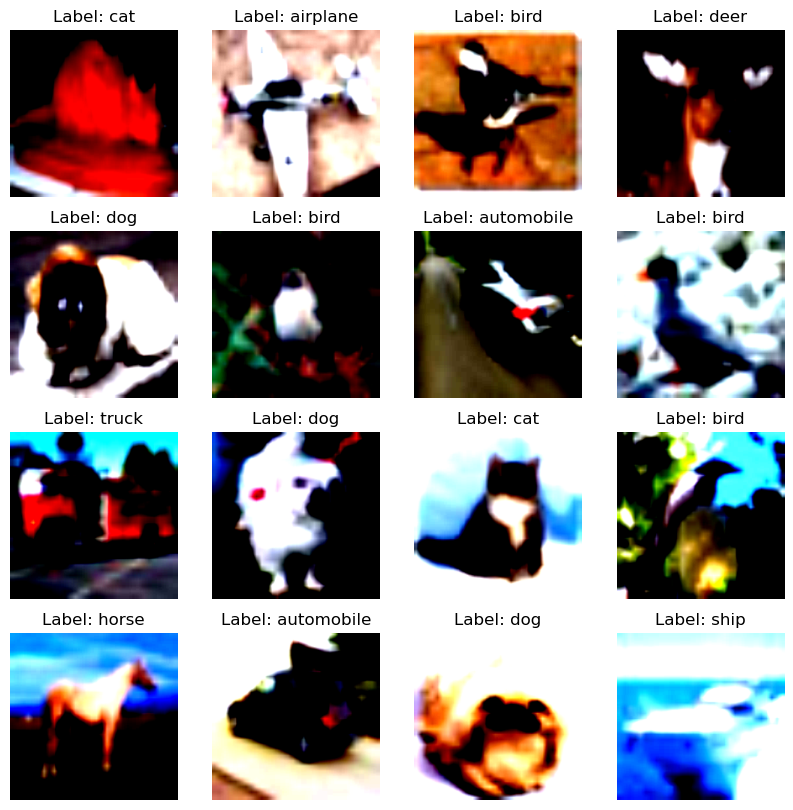

In [6]:
#random sample the dataset and plot on of the pictures
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
cols, rows = 4,4
fig,ax = plt.subplots(rows, cols,figsize=(10,10))
for i in range(rows):
    images, labels = data_iter.next()
    for j in range(cols):
        ax[i][j].axis("off")
        ax[i][j].imshow(images[j].squeeze().permute(1, 2, 0))
        ax[i][j].set_title(f'Label: {classes[labels[j].item()]}')

In [7]:
class ConvUnit(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, relu=True, **kwargs):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.norm = torch.nn.BatchNorm2d(out_channels)
        
        if relu:
            self.relu = torch.nn.ReLU()
        else:
            self.relu = torch.nn.Sequential()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [8]:
class SoftMaskBranch(torch.nn.Module):
    
    def __init__(self):
        pass
    
    def forward(self, x):
        return x

In [9]:
class AttentionModule(torch.nn.Module):
    
    def __init__(self, p=1, t=2, r=1):
        
        self.preprocess = torch.nn.Sequential(
            [ResUnit()] * p
        )
        
        self.t = torch.nn.Sequential(
            [ResUnit()] * t
        )
        
        self.m = torch.nn.Sequential(
            
        )
        
    
    def forward(self, x):
        x = self.preprocess(x)
        trunk = self.t(x)
        mask = self.m(x)
        
        
        return x

In [10]:
class ResUnit(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.shortcut = ConvUnit(in_channels, out_channels, 1)
        
        self.conv1 = ConvUnit(in_channels, in_channels, 1, padding=1)
        self.conv2 = ConvUnit(in_channels, in_channels, 3)
        self.conv3 = ConvUnit(in_channels, out_channels, 1, relu=False)
        self.relu = torch.nn.ReLU()
        
        
    def forward(self, x):
        shortcut = self.shortcut(x)
        print(shortcut.shape)
        res = self.conv1(x)
        res = self.conv2(res)
        res = self.conv3(res)
        print(res.shape)
        
        x = res + shortcut
        x = self.relu(x)
        
        return x

In [11]:
class Attention56(torch.nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.conv1 = ConvUnit(3, 64, 7, stride=2, padding=3)
        self.pool1 = torch.nn.MaxPool2d(3, 2, padding=1)
        self.res1 = ResUnit(64, 256)
        
        self.res2 = ResUnit(128, 512)
        
        self.res3 = ResUnit(256, 1024)
        
        self.res4 = ResUnit(512, 2048)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.res1(x)
#         x = self.res2(x)
#         x = self.res3(x)
#         x = self.res4(x)
        print(x.shape)

        return x

In [12]:
import torch.optim as optim
import time

learning_rate = 0.005

net = Attention56(len(classes)).to(device)

critereon = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

In [13]:
class Summary:
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def all_reduce(self):
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
        total = torch.tensor([self.sum, self.count], dtype=torch.float32, device=device)
        dist.all_reduce(total, dist.ReduceOp.SUM, async_op=False)
        self.sum, self.count = total.tolist()
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [14]:
def train(train_loader, model, criterion, optimizer, epoch, device, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # move data to the same device as model
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args['print_freq'] == 0:
            progress.display(i + 1)
    
    return model, progress
            
            
    

In [15]:
args = {'print_freq':10}
model, progress = train(train_loader, net, critereon, optimizer, 1, device, args)

torch.Size([256, 256, 56, 56])
torch.Size([256, 256, 56, 56])


RuntimeError: Given groups=1, weight of size [512, 128, 1, 1], expected input[256, 256, 56, 56] to have 128 channels, but got 256 channels instead

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
        
        if i % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, 100 * correct / total))

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

In [ ]:
import numpy as np
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    
    if allkernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.ioff()
    plt.show()